Slayer for Image Recognition using CIFAR-10

In [ ]:
!pip install git+https://github.com/lava-nc/lava-dl

  Cloning https://github.com/lava-nc/lava-dl to /tmp/pip-req-build-j_q3s0eg
  Running command git clone --filter=blob:none --quiet https://github.com/lava-nc/lava-dl /tmp/pip-req-build-j_q3s0eg
  Resolved https://github.com/lava-nc/lava-dl to commit a9d9603498a2b88d84dc59ca3e875eaae16e2fd2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/lava-nc/lava.git (to revision main) to /tmp/pip-install-a_56t5_j/lava-nc_77a04efcc9ec4144b17096a2f795a4f2
  Running command git clone --filter=blob:none --quiet https://github.com/lava-nc/lava.git /tmp/pip-install-a_56t5_j/lava-nc_77a04efcc9ec4144b17096a2f795a4f2
  Resolved https://github.com/lava-nc/lava.git to commit 19ef85114140bb79ed90cb7a661c0056240bca55
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.to

In [ ]:
!pip install gitpython
from IPython.display import clear_output
clear_output()

import os, shutil
from git import Repo

try:
    # Check if this cell is running in google colab
    import google.colab

    # Delete everything in the content (current) directory on google colab
    for root, dirs, files in os.walk("/content"):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            shutil.rmtree(os.path.join(root, name))
        break

    # Clone git repo, change the branch and
    Repo.clone_from("https://github.com/lava-nc/lava-dl", "/content/lava-dl")

    # Move the repo up by one level in the folder hierarchy
    for root, dirs, files in os.walk("/content/lava-dl"):
        for name in dirs + files:
            shutil.move(os.path.join(root, name), os.path.join("/content", name))
        break
    os.rmdir("/content/lava-dl")

except:
    print("This cell is only supposed to be executed on google colab, not on your local machine!")

## Imports

In [ ]:
import os, sys
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import IPython.display as display
from matplotlib import animation

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

#from tutorials.lava.lib.dl.slayer.nmnist.nmnist import NMNISTDataset, augment

In [ ]:

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}

        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 128*128*2, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, 512, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 10, weight_norm=True),
            ])

    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike

    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad
    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

# Working import

## Original download

In [ ]:
#! pip install spikingjelly

In [ ]:
#from spikingjelly.datasets import cifar10_dvs
#from spikingjelly.datasets import split_to_train_test_set

In [ ]:
#dataset = cifar10_dvs.CIFAR10DVS('/content/CIFAR', data_type = 'frame', frames_number = 10, split_by = 'number',
#transform = None, target_transform = None)

In [ ]:
#train_dataset, val_dataset  = split_to_train_test_set(train_ratio = 0.7, origin_dataset = dataset, num_classes= 10)

In [ ]:
#torch.save(val_dataset, '/content/drive/MyDrive/CIFAR/val_dataset.pth')

In [ ]:
#!zip -r /content/CIFAR/events_np.zip /content/CIFAR/events_np

## Later import only needed files from google colab / upload to content

In [ ]:
! pip install spikingjelly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive


drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
zip_filename = '/content/drive/MyDrive/frames_number_10_split_by_number.zip'
extract_folder = '/content/frames_number_10_split_by_number'

!unzip {zip_filename} -d {extract_folder}

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/frames_number_10_split_by_number/content/CIFAR/frames_number_10_split_by_number/horse/cifar10_horse_905.npz  
  inflating: /content/frames_number_10_split_by_number/content/CIFAR/frames_number_10_split_by_number/horse/cifar10_horse_510.npz  
  inflating: /content/frames_number_10_split_by_number/content/CIFAR/frames_number_10_split_by_number/horse/cifar10_horse_793.npz  
  inflating: /content/frames_number_10_split_by_number/content/CIFAR/frames_number_10_split_by_number/horse/cifar10_horse_480.npz  
  inflating: /content/frames_number_10_split_by_number/content/CIFAR/frames_number_10_split_by_number/horse/cifar10_horse_643.npz  
  inflating: /content/frames_number_10_split_by_number/content/CIFAR/frames_number_10_split_by_number/horse/cifar10_horse_224.npz  
  inflating: /content/frames_number_10_split_by_number/content/CIFAR/frames_number_10_split_by_number/horse/cifar10_horse_550.npz  
  inflating: /content/fram

In [ ]:
import shutil
import os

# Specify the folder and the target directory
folder_to_move = '/content/frames_number_10_split_by_number/content/CIFAR'
target_directory = '/content'  # Move up one level in the hierarchy

# Create the target directory if it doesn't exist
os.makedirs(target_directory, exist_ok=True)

# Move the folder to the target directory
shutil.move(folder_to_move, target_directory)

'/content/CIFAR'

In [ ]:
import torch
val_path = '/content/drive/MyDrive/val_dataset.pth'
train_path = '/content/drive/MyDrive/train_dataset.pth'
# Load the model
test_val_dataset_loaded= torch.load(val_path)
train_dataset_loaded= torch.load(train_path)

In [ ]:
import tqdm
import math
import numpy as np
def split_to_train_test_set(train_ratio: float, origin_dataset: torch.utils.data.Dataset, num_classes: int, random_split: bool = False):
    '''
    :param train_ratio: split the ratio of the origin dataset as the train set
    :type train_ratio: float
    :param origin_dataset: the origin dataset
    :type origin_dataset: torch.utils.data.Dataset
    :param num_classes: total classes number, e.g., ``10`` for the MNIST dataset
    :type num_classes: int
    :param random_split: If ``False``, the front ratio of samples in each classes will
            be included in train set, while the reset will be included in test set.
            If ``True``, this function will split samples in each classes randomly. The randomness is controlled by
            ``numpy.random.seed``
    :type random_split: int
    :return: a tuple ``(train_set, test_set)``
    :rtype: tuple
    '''
    label_idx = []
    for i in range(num_classes):
        label_idx.append([])

    for i, item in enumerate(tqdm.tqdm(origin_dataset)):

        y = item[1]

        if isinstance(y, np.ndarray) or isinstance(y, torch.Tensor):
            y = y.item()
        label_idx[y].append(i)
    train_idx = []
    test_idx = []
    if random_split:
        for i in range(num_classes):
            np.random.shuffle(label_idx[i])

    for i in range(num_classes):
        pos = math.ceil(label_idx[i].__len__() * train_ratio)
        train_idx.extend(label_idx[i][0: pos])
        test_idx.extend(label_idx[i][pos: label_idx[i].__len__()])

    return torch.utils.data.Subset(origin_dataset, train_idx), torch.utils.data.Subset(origin_dataset, test_idx)


In [ ]:
def load_npz_frames(file_name: str) -> np.ndarray:
    '''
    :param file_name: path of the npz file that saves the frames
    :type file_name: str
    :return: frames
    :rtype: np.ndarray
    '''
    return np.load(file_name, allow_pickle=True)['frames'].astype(np.float32)

In [ ]:
import torchvision

In [ ]:
test_ds = torchvision.datasets.DatasetFolder('/content/CIFAR/frames_number_10_split_by_number', loader = load_npz_frames, extensions=('.npz', '.npy'))#, data_type = 'frame', frames_number = 10, split_by = 'number')

In [ ]:
training_set, testing_validation_set = split_to_train_test_set(0.7, test_ds, 10)

100%|██████████| 10000/10000 [01:17<00:00, 129.55it/s]


In [ ]:
#split_to_train_test_set(0.7, dataset, 10)

In [ ]:
import time
from torch.utils.data import Subset, random_split
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

device = torch.device('cuda')
# Get wakeup time
start_time = time.time()
net = Network().to(device)
end_time = time.time()
wakeup_time = end_time - start_time
print(f"Wakeup time: {wakeup_time:.4f} seconds")

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

#PUT THEM BACK
#training_set = train_dataset_loaded
#testing_validation_set  = test_val_dataset_loaded
subset_size = len(testing_validation_set)
subset1_size = subset_size // 2
subset2_size = subset_size - subset1_size

# Use random_split to split the initial subset randomly
val_set, testing_set = random_split(testing_validation_set, [subset1_size, subset2_size])
train_loader = DataLoader(dataset=training_set, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=16, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=16, shuffle=True)

Wakeup time: 2.9230 seconds


In [ ]:
error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)

In [ ]:
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

In [ ]:
#torch.cuda.init()
#torch.cuda.empty_cache()

In [ ]:
import time
#import torch.autograd.profiler as profiler
import tracemalloc

In [ ]:
import time
#import torch.autograd.profiler as profiler
import tracemalloc
start_time = time.time()
tracemalloc.start()
#with profiler.profile(record_shapes=True, use_cuda=torch.cuda.is_available()) as prof:
def train_one_epoch(epoch, epochs):
      for i, (input, label) in enumerate(train_loader): # training loop
          if np.shape(input.reshape(train_loader.batch_size, -1,10))[1] == 32768:
            output = assistant.train(input.reshape(train_loader.batch_size, -1,10), label)

          #else:
          # print("OTHER SHAPE")
            #print(np.shape(input))

      print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

      latency_sum = 0
      num_batches = 0
      troughput_start_time = time.time()
      for i, (input, label) in enumerate(val_loader): # test loop Inference time?
          if np.shape(input.reshape(val_loader.batch_size, -1,10))[1] == 32768:

            start_time = time.time()

            # Inference without gradient calculation
            with torch.no_grad():
                output = assistant.test(input.reshape(val_loader.batch_size, -1, 10), label)

            # Record end time
            end_time = time.time()

            # Measure and accumulate latency for each test batch
            latency_batch = end_time - start_time
            latency_sum += latency_batch
            num_batches += 1
      troughput_end_time = time.time()
      print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
      print('\n')
      average_latency = latency_sum / num_batches if num_batches > 0 else 0
      throughput_time = troughput_end_time - troughput_start_time
      throughput = num_batches / throughput_time if throughput_time > 0 else 0
      print(f'[Epoch {epoch}/{epochs}] Average Latency: {average_latency:.4f} seconds')
      print('\n')
      if epoch%20 == 19: # cleanup display
          print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
          stats_str = str(stats).replace("| ", "\n")
          print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')

      if stats.testing.best_accuracy:
          torch.save(net.state_dict(), trained_folder + '/network.pt')
      stats.update()
      stats.save(trained_folder + '/')
      net.grad_flow(trained_folder + '/')
      return average_latency, throughput

# End measuring time
memory_per_episode = []
episodes= 15

epoch_latency = []
epoch_throughputs = []
for epoch in range(1, episodes+1):
  tracemalloc.start()
  latency, throughput = train_one_epoch(epoch, episodes)
  epoch_latency.append(latency)
  epoch_throughputs.append(throughput)
#train(1)
  snapshot = tracemalloc.take_snapshot()
  tracemalloc.stop()
 # top_stats = snapshot.statistics('lineno')
  epoch_size = 0
  for line_stat in snapshot.statistics('lineno'):
    epoch_size += line_stat.size

  memory_per_episode.append(epoch_size)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Average Latency over all epochs: ", np.average(epoch_latency))
print(f"Average Throughput over all epochs: ", np.average(epoch_throughputs))
print(f"Average memory attributed per epoch: {np.average(memory_per_episode)/ 1e6} MBit with standard deviation: {np.std(memory_per_episode)/ 1e3} KBit")
print(f"Total training time: {elapsed_time} seconds")


[Epoch  1/15] Train loss =     0.76990                          accuracy = 0.10026  | Test  loss =     0.76960                          accuracy = 0.10618 

[Epoch 1/15] Average Latency: 0.0230 seconds


[Epoch  2/15] Train loss =     0.78333 (min =     0.76990)     accuracy = 0.10898 (max = 0.10026)  | Test  loss =     0.78764 (min =     0.76960)     accuracy = 0.11089 (max = 0.10618) 

[Epoch 2/15] Average Latency: 0.0231 seconds


[Epoch  3/15] Train loss =     0.76904 (min =     0.76990)     accuracy = 0.12686 (max = 0.10898)  | Test  loss =     0.75485 (min =     0.76960)     accuracy = 0.14046 (max = 0.11089) 

[Epoch 3/15] Average Latency: 0.0233 seconds


[Epoch  4/15] Train loss =     0.74927 (min =     0.76904)     accuracy = 0.13816 (max = 0.12686)  | Test  loss =     0.73919 (min =     0.75485)     accuracy = 0.15995 (max = 0.14046) 

[Epoch 4/15] Average Latency: 0.0229 seconds


[Epoch  5/15] Train loss =     0.73484 (min =     0.74927)     accuracy = 0.15017 (max = 0.138

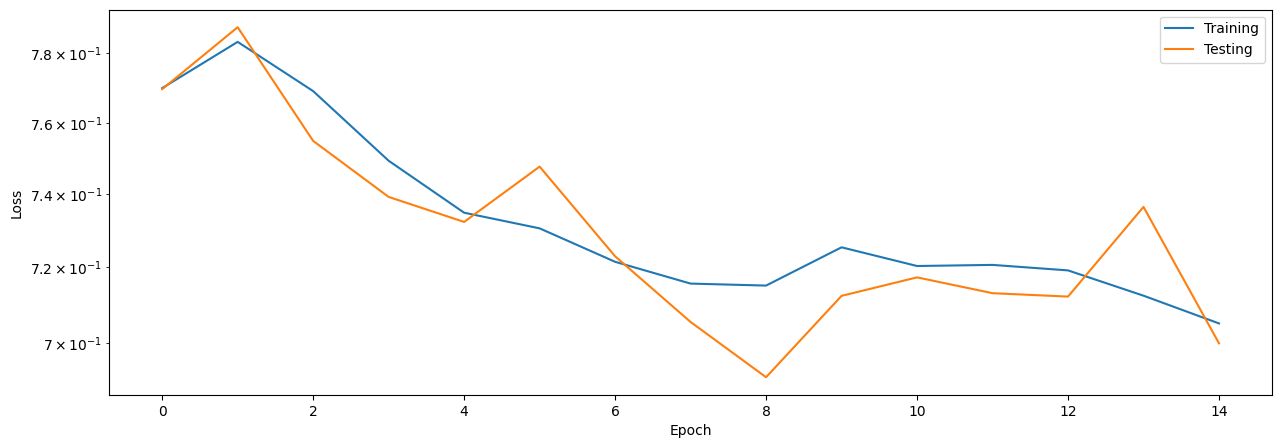

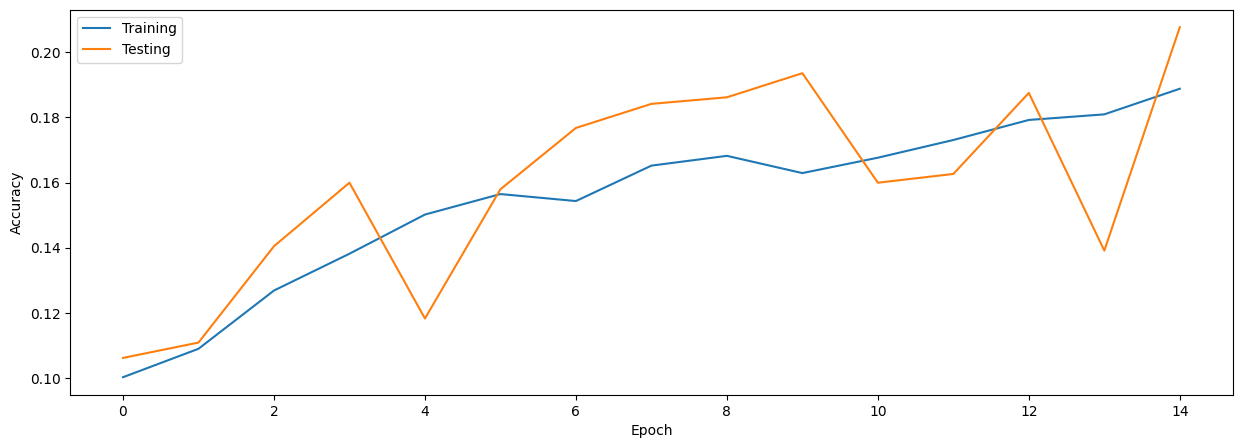

In [ ]:
stats.plot(figsize=(15, 5))

In [ ]:
all_labels = []
all_preds= []

for i, (input, label) in enumerate(test_loader): # test loop
    if np.shape(input.reshape(val_loader.batch_size, -1,10))[1] == 32768:
        output = assistant.test(input.reshape(test_loader.batch_size, -1, 10), label)
        pred = slayer.classifier.Rate.predict(output)
        all_labels.append(pred)
        all_preds.append(label)


In [ ]:
print(all_preds)

[tensor([9, 6, 9, 7, 4, 1, 8, 5, 8, 1, 4, 4, 0, 8, 3, 5]), tensor([4, 0, 5, 2, 5, 0, 4, 4, 3, 0, 9, 8, 5, 6, 5, 2]), tensor([1, 2, 2, 4, 1, 6, 7, 3, 0, 3, 2, 4, 3, 6, 7, 7]), tensor([9, 6, 4, 3, 0, 7, 7, 5, 3, 1, 5, 0, 5, 7, 4, 5]), tensor([2, 0, 6, 7, 1, 9, 1, 5, 4, 0, 3, 8, 1, 6, 7, 5]), tensor([5, 3, 9, 1, 2, 3, 9, 8, 9, 0, 0, 1, 4, 0, 3, 3]), tensor([8, 9, 2, 8, 8, 9, 7, 7, 2, 8, 8, 6, 0, 5, 9, 5]), tensor([5, 0, 0, 1, 2, 8, 2, 1, 8, 0, 7, 6, 6, 8, 7, 4]), tensor([2, 8, 6, 6, 4, 0, 1, 8, 7, 9, 0, 2, 0, 7, 2, 3]), tensor([3, 8, 9, 3, 5, 2, 6, 1, 6, 3, 3, 5, 4, 3, 6, 2]), tensor([4, 7, 6, 7, 0, 1, 4, 8, 9, 7, 8, 4, 2, 0, 3, 2]), tensor([4, 3, 2, 3, 2, 4, 6, 8, 4, 2, 2, 5, 3, 6, 1, 9]), tensor([4, 7, 1, 4, 2, 4, 6, 6, 3, 9, 6, 5, 8, 6, 5, 5]), tensor([1, 0, 3, 2, 2, 7, 0, 3, 7, 7, 1, 9, 1, 7, 0, 5]), tensor([5, 0, 8, 4, 7, 1, 4, 5, 7, 5, 0, 2, 0, 8, 0, 8]), tensor([7, 5, 7, 7, 0, 3, 9, 6, 6, 5, 0, 7, 3, 6, 1, 3]), tensor([7, 7, 4, 1, 5, 1, 4, 7, 0, 7, 2, 8, 4, 2, 0, 3]), tensor([6, 9,

In [ ]:
def download_as_tensor(filename, list):
  flat_all_labels = []
  for tensor in list:
    for tensor2 in tensor:
        flat_all_labels.append(tensor2.cpu().numpy())
      #flat_all_labels.append(tensor2.cpu().numpy())
  flat_all_labels = np.array(flat_all_labels).flatten()
  torch.save(flat_all_labels, filename)

In [ ]:
download_as_tensor('all_labels.pt', all_labels)
download_as_tensor('all_preds.pt', all_preds)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, average_precision_score
import torch
all_labels = torch.load('all_labels.pt')
all_preds = torch.load('all_preds.pt')
f1 = f1_score(all_labels, all_preds, average='macro')
print(f'F1 Score: {f1}')
roc_fpr = []
roc_tpr = []

for i in range(0,9):
  fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label = i)
  roc_fpr.append(fpr)
  roc_tpr.append(tpr)

plt.figure(figsize=(4, 4))
plt.plot(np.average(roc_fpr, axis = 0), np.average(roc_tpr, axis = 0), label = 'decolle')

plt.legend()

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')


AttributeError: ignored

In [ ]:
def get_AUC(y_true, preds):
  for j in range(0,9):
    binary_y_true = np.zeros(len(y_true))
    preds_binary = np.zeros(len(y_true))
    for i in range(len(y_true)):
      if (y_true[i] == j):
        binary_y_true[i] = 1
      if (preds[i] == j):
        preds_binary[i] = 1

  return roc_auc_score(binary_y_true, preds_binary)

auc = get_AUC(all_labels, all_preds)
print(f'AUC: {auc}')

RuntimeError: ignored

In [ ]:
def get_TRP_FRP(y_true, preds):
  confusion = confusion_matrix(y_true, preds)

  TRPs_Decolle = []
  for class_index in range(0,9):
    TP = confusion[class_index, class_index]
    FN = np.sum(confusion[class_index, :]) - TP

    TRPs_Decolle.append(TP / (TP + FN))

  FRPs_Decolle = []
  for class_index in range(0,9):
    FP = confusion[class_index, class_index]
    TN = np.sum(confusion) - np.sum(confusion[class_index, :]) - np.sum(confusion[:, class_index]) + FP

    FRPs_Decolle.append(TP / (TP + FN))

  return str(np.average(TRPs_Decolle)), str(np.average(FRPs_Decolle))

trp_decolle, frp_decolle = get_TRP_FRP(all_labels,all_preds)
print('Average true positive rate: ' + trp_decolle)
print('Average false positive rate: ' + frp_decolle)

NameError: ignored

In [ ]:
def true_negative_rate(y_true, y_pred):
    # Assuming y_true and y_pred are arrays/lists of true labels and predicted labels, respectively.
    tn = sum((y_true == 0) & (y_pred == 0))  # True negatives
    fp = sum((y_true == 0) & (y_pred == 1))  # False positives

    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0.0  # True Negative Rate (Specificity)

    return tnr
tnr = true_negative_rate(all_labels, all_preds)
print("True Negative Rate:", tnr)

TypeError: ignored

In [ ]:
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
def get_precision(y_true, preds):
  for j in range(0,9):
    binary_y_true = np.zeros(len(y_true))
    preds_binary = np.zeros(len(y_true))
    for i in range(len(y_true)):
      if (y_true[i] == j):
        binary_y_true[i] = 1
      if (preds[i] == j):
        preds_binary[i] = 1

  return average_precision_score(binary_y_true,preds_binary)

print("Average precision: ", get_precision(all_labels,all_preds))

AttributeError: ignored

In [ ]:
from sklearn.metrics import f1_score, average_precision_score, precision_score,accuracy_score
precision_score(all_labels,all_preds, average = "macro")

AttributeError: ignored

In [ ]:
print("Accuracy: ", accuracy_score(all_labels,all_preds))

NameError: ignored

**Energy Consumption Metric:** This metric assesses the average energy usage for both wake-up time and training time while running the model in Google Colab.

These measurements are based on average times, as referenced from the specific energy consumption www.green-algorithms.org website (Energy Consupmtion for 1 Google Cloud GPU). These values are estimates and provide a general overview of energy usage due to the varied nature of tasks and hardware configurations in cloud-based environments.

In [ ]:
# Definition of Average Power Usage

# This values are taken from last run. Remove this when re run it
wakeup_time = 0.3127 #(seconds)
elapsed_time = 1358.12 #(seconds)

# Average power usage in watts (Based on the green-algorithms.org)
# Google Cloud GPU NVIDIA Tesla T4 Memory Available 16 GB per 1 hour will give 82.80 Wh per hour
average_power_usage_watts = 82.80

# Calculate energy consumption for wakeup time in Joules
energy_consumption_wakeup_Joules = average_power_usage_watts * wakeup_time
print(f"Estimated energy consumption for wakeup: {energy_consumption_wakeup_Joules} Joules")

Estimated energy consumption for wakeup: 25.89156 Joules


In [ ]:
# Calculate energy consumption for training and testing in Joules
energy_consumption_training_testing_Joules = average_power_usage_watts * elapsed_time
print(f"Estimated energy consumption for training and testing: {energy_consumption_training_testing_Joules} Joules")

Estimated energy consumption for training and testing: 112452.33599999998 Joules


In [ ]:
# Total energy consumption in Joules
total_energy_consumption_Joules = energy_consumption_wakeup_Joules + energy_consumption_training_testing_Joules
print(f"Total estimated energy consumption: {total_energy_consumption_Joules} Joules")

Total estimated energy consumption: 112478.22755999998 Joules


In [ ]:
# epoch_size = 0
# for line_stat in snapshot.statistics('lineno'):
#   epoch_size += line_stat.size

# print("Total allocated bytes in epoch: ",epoch_size)

In [ ]:
# net.load_state_dict(torch.load(trained_folder + '/network.pt'))
# net.export_hdf5(trained_folder + '/network.net')

In [ ]:
# net.load_state_dict(torch.load(trained_folder + '/network.pt'))

In [ ]:
# torch.save(targets_slayer, trained_folder + '/targets_slayer.pt')
# torch.save(pred_slayer, trained_folder + '/pred_slayer.pt')

In [ ]:
# from google.colab import files
# !zip -r /content/Trained.zip /content/Trained
# files.download('/content/Trained.zip')

# Memory

* **On-Chip Memory Size**: in megabytes in the hardware specifications or documentation of the GPUs and neuromorphic chips we are comparing. This information should be available in the technical specifications of the hardware used.

* **Average Memory Attributed per Epoch**: The memory_per_episode list in the code below contains the memory attributed for each epoch. You can calculate the average memory attributed per epoch by taking the mean of this list.

other key metrics related to space utilization and computational efficiency:

* Model Size: size of neural network model. This includes the size of all the parameters (weights and biases) in the model. This can be obtained by saving the model's state dictionary and measuring its size.

* Parameters Utilization: Calculate the utilization of model parameters. This is the ratio of the actual on-chip memory used by the model parameters to the total available on-chip memory.

* Throughput and Latency: These metrics provide insights into the speed and efficiency of the model during both training and inference. You already have code for calculating throughput in your training loop.

In [ ]:
import numpy as np

# Assuming memory_per_episode is a list containing memory attributed for each epoch
average_memory_per_epoch = np.average(memory_per_episode) / 1e6  # in Megabytes

# Optionally, you can calculate the standard deviation
std_memory_per_epoch = np.std(memory_per_episode) / 1e6  # in Megabytes

print(f"Average Memory Attributed per Epoch: {average_memory_per_epoch:.2f} MB")
print(f"Standard Deviation of Memory Attributed per Epoch: {std_memory_per_epoch:.2f} MB")


Average Memory Attributed per Epoch: 3.12 MB
Standard Deviation of Memory Attributed per Epoch: 0.88 MB


In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Get the GPU device name
    gpu_name = torch.cuda.get_device_name(0)

    # Get the total GPU memory
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to gigabytes

    print(f"GPU Name: {gpu_name}")
    print(f"Total GPU Memory: {gpu_memory:.2f} GB")
else:
    print("GPU not available.")


GPU Name: Tesla T4
Total GPU Memory: 15.84 GB


In [ ]:
# Assuming 'state_dict' is your loaded state dictionary
state_dict = torch.load("/content/Trained/network.pt")

# Calculate the model size based on the state dictionary
model_size_bytes = sum(tensor.numel() * tensor.element_size() for tensor in state_dict.values())
model_size_MB = model_size_bytes / (1024 ** 2)  # Convert to Megabytes

print(f"Model Size: {model_size_MB:.2f} MB")

Model Size: 65.03 MB


In [ ]:
### Parameters utilization
on_chip_memory_size_MB = 15840.0  # Actual size of Tesla T4 GPU memory in megabytes

parameters_utilization = model_size_MB / on_chip_memory_size_MB * 100  # Percentage

print(f"Parameters Utilization: {parameters_utilization:.2f}%")



Parameters Utilization: 0.41%


In [ ]:
### Throughput and latency

average_inference_latency = np.average(epoch_latency)
average_inference_throughput = np.average(epoch_throughputs)

print(f"Average Inference Latency: {average_inference_latency:.4f} seconds")
print(f"Average Inference Throughput: {average_inference_throughput:.2f} batches per second")

Average Inference Latency: 0.0228 seconds
Average Inference Throughput: 6.33 batches per second
